In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

from glob import glob
from dask.delayed import delayed
import dask.dataframe as dd
import pandas as pd
import numpy as np
from functools import reduce
from tqdm import tqdm

import matplotlib.pylab as plt
plt.style.use('ggplot')

from utils import read_ngrams, save_ngrams

In [2]:
df_raw = read_ngrams("/mnt/volume_sfo2_03/downloads/google_ngrams/5/constitution-parsed-gz/part-*")
df_raw.columns = ['query', 'r1', 'r2', 'r3', 'year', 'total', 'distinct']
df_raw = df_raw.compute()

In [3]:
df = (pd.concat([
    df_raw[['query', w, 'year', 'total', 'distinct']].rename(columns={w: 'w'})
    for w in ['r1', 'r2', 'r3']
]).groupby(['w', 'query', 'year'])
      .sum()
      .reset_index())

df = df[df['year'] >= 1788]

df.sample(10, random_state=42)

,w,query,year,total,distinct
106834,command,sixth amendment,1958,2,2
382109,than,sixth amendment,1993,22,18
44983,action,fourteenth amendment,1954,7,6
350542,scope,eighth amendment,1975,1,1
430140,when,seventeenth amendment,1993,2,2
206746,human,fifth amendment,1971,1,1
215834,inches,fourth amendment,2002,1,1
1020,"""",fourth amendment,1955,9,7
359913,significantly,first amendment,1994,6,6
8776,",",fourth amendment,1956,29,25


In [4]:
df_ratios = (df.groupby(['w', 'query'])[['total', 'distinct']].sum() / (df.groupby(['w'])[['total', 'distinct']].sum() + 2)).reset_index()

def pad(x, n):
    return np.pad(x, (0, n-len(x)), 'constant', constant_values=(np.nan, np.nan))

def nlargest(df, n):
    return pd.DataFrame({
        q: pad(x.nlargest(n, 'total')['w'].values, n)
        for q, x in df_ratios.sort_values(['query', 'total'], ascending=False).groupby('query')
    }).T.reindex(df['query'].unique())

nlargest(df_ratios, 8)


,0,1,2,3,4,5,6,7
eighteenth amendment,volstead,temperance,manufacture,reform,opponents,failure,sale,f.
fifth amendment,plead,taking,selfincrimination,pleaded,takings,asked,jeopardy,communists
first amendment,religion,establishment,center,alleged,forum,regulation,erected,committee
fourteenth amendment,1868,via,transformation,citizenship,perverted,enunciated,absorbed,undoubtedly
article one,eight,ten,tribunal,chapter,follows,fully,8,two
article two,roadmap,warranties,uniform,project,ucc,steam,strokes,73
eighth amendment,cruel,bail,penalty,execution,death,addresses,mccleskey,setting
eleventh amendment,sovereign,1798,dismissed,gibbons,restricts,exhausts,jan.,jacobs
fifteenth amendment,1870,1869,march,1870-1877,justifying,supersedes,interdicts,equitable
fourth amendment,search,reasonableness,probable,becomes,enforceable,tested,warrantless,wrong


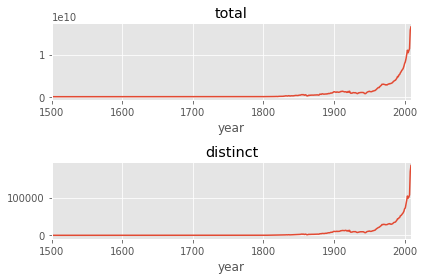

In [5]:
df_baseline = pd.read_csv("/mnt/volume_sfo2_02/googlebooks-eng-us-all-totalcounts-20120701.txt",
                          lineterminator='\t',
                          names=['year', 'total', 'page', 'distinct']).set_index('year')
_, axes = plt.subplots(nrows=2, ncols=1)
df_baseline['total'].plot(ax=axes[0], title='total')
df_baseline['distinct'].plot(ax=axes[1], title='distinct')
plt.tight_layout()


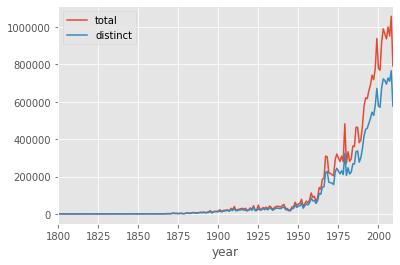

In [6]:
df.groupby(['year'])[['total', 'distinct']].sum().plot();

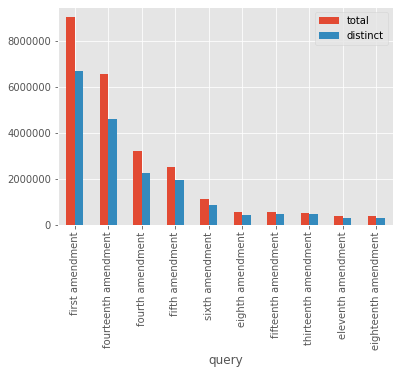

In [7]:
df_queries = (df.groupby(['query'])[['total', 'distinct']]
     .sum()
     .sort_values('total', ascending=False))

(df_queries.nlargest(10, 'total')
     .plot.bar());

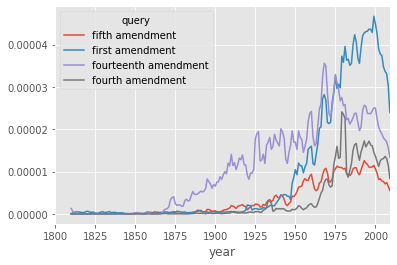

In [8]:
top_n = df_queries.nlargest(4, 'total').index

df_query_year = (
    df.groupby(['query', 'year'])[['total', 'distinct']].sum() /
    (df_baseline)
)

(df_query_year.loc[top_n, :]
     .unstack('query')['total']
     .reindex([q for q in df['query'].unique() if q in top_n], axis=1)
     .fillna(0)
     .sort_index()
     .rolling(3)
     .mean()
     .plot())

# Similar to https://books.google.com/ngrams/graph?content=first+amendment%2Cfourteenth+amendment%2Cfourth+amendment%2Cfifth+amendment&case_insensitive=on&year_start=1800&year_end=2008&corpus=17&smoothing=2&share=&direct_url=t4%3B%2Cfirst%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFirst%20Amendment%3B%2Cc0%3B%3Bfirst%20amendment%3B%2Cc0%3B%3Bfirst%20Amendment%3B%2Cc0%3B.t4%3B%2Cfourteenth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourteenth%20Amendment%3B%2Cc0%3B%3Bfourteenth%20amendment%3B%2Cc0%3B.t4%3B%2Cfourth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourth%20Amendment%3B%2Cc0%3B%3Bfourth%20amendment%3B%2Cc0%3B%3Bfourth%20Amendment%3B%2Cc0%3B.t4%3B%2Cfifth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFifth%20Amendment%3B%2Cc0%3B%3Bfifth%20amendment%3B%2Cc0%3B%3Bfifth%20Amendment%3B%2Cc0#t4%3B%2Cfirst%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFirst%20Amendment%3B%2Cc0%3B%3Bfirst%20amendment%3B%2Cc0%3B%3Bfirst%20Amendment%3B%2Cc0%3B.t4%3B%2Cfourteenth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourteenth%20Amendment%3B%2Cc0%3B%3Bfourteenth%20amendment%3B%2Cc0%3B.t4%3B%2Cfourth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourth%20Amendment%3B%2Cc0%3B%3Bfourth%20amendment%3B%2Cc0%3B%3Bfourth%20Amendment%3B%2Cc0%3B.t4%3B%2Cfifth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFifth%20Amendment%3B%2Cc0%3B%3Bfifth%20amendment%3B%2Cc0%3B%3Bfifth%20Amendment%3B%2Cc0
